# Applying Deep Learning Techniques to Diagnose Pneumonia Using Lung X-ray Images
- By Riyaan Jain, Kashan Ali, and Yash Deswal
- Please find the corresponding research paper here: https://www.riyaanjainportfolio.com

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
from fastai.metrics import Precision, Recall, F1Score

In [2]:
from fastai.vision.all import *

# Background
- This is our project for altREU: Design, Program, and Use Computers to Benefit Society.
- Pneumonia is a leading cause of death worldwide, and the number one cause of mortality for children caused by an infectious disease.
- Chest X-rays are vital in detecting and diagnosing pneumonia, and are one of the most ordered radiological reports, but there is a disproportionate lack of radiology specialists to interpret these X-ray images.
- We present a tool which implements a convolutional neural network and interprets chest X-ray images and provides a pneumonia diagnosis.
- Our goal is to provide a tool to assist medical professionals in diagnosing pneumonia using chest X-ray images, which is often difficult to interpret due to the great subtleties in radiological features between healthy and infected lungs.

# Approach
- We use the Chest X-ray Dataset with Lung Segmentation, found on PhysioNet, which is a large dataset of segmented X-ray images derived from the MIMIC-CXR-JPG dataset.
- The program will take a lung X-ray image of a patient as input and output whether that patient has pneumonia and the degree to which it is certain of its decision.
- To serve its purpose as an assisstive tool to medical professionals, the program also outputs a heatmap highlighting the regions of interest to the model in its diagnosis, implemented using Gradient-weighted Class Activation Mapping (Grad-CAM).
- Upon experimenting with implementations built using TensorFlow and PyTorch, we found that fastai on Python is the most intuitive and powerful tool for our project.

In [3]:
# The dataset is randomly split into train, test, and validation folders by a sorting algorithm, and then uploaded to kaggle.
# It is split into 80:10:10 for train, test, and validation. There are 35k images in total.
# Within each of train, test, and val, there are already two folders consisting of non-pneumonia and pneumonia X-ray images.

train_path = Path('/kaggle/input/full-dataset/kaggle/working/train')
valid_path = Path('/kaggle/input/full-dataset/kaggle/working/val')
test_path = Path('/kaggle/input/full-dataset/kaggle/working/test')

# Creates a DataLoader object using the pre-split train and validation datasets.

data = ImageDataLoaders.from_folder(
    train_path.parent,
    train = 'train', 
    valid = 'val', 
    item_tfms = Resize(224), 
    batch_tfms = aug_transforms(), 
    num_workers = 4
)

# Loads metrics

precision = Precision()
recall = Recall()
f1 = F1Score()

In [4]:
# Prints the classes to verify.

print(data.vocab)
print(f"Number of classes: {len(data.vocab)}")
print(f"Number of output categories: {data.c}")

['normal', 'pneumonia']
Number of classes: 2
Number of output categories: 2


In [5]:
# Create a learner object with ResNet50 model.
# We chose ResNet50 for its higher accuracy compared to VGG16, but quicker training and fine-tuning times
# compared to Nick Muchi's model found on the HuggingFace website (see below).

learn = vision_learner(
    data, 
    resnet50,
    metrics = [accuracy, precision, recall, f1],
    path=Path("."), 
    model_dir=Path("/kaggle/working/models")
)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 62.7MB/s]


- Nick Muchi's model from HuggingFace website. It took too long to train, approximately 3x as long per epoch than ResNet50.
- Due to kaggle's 12 hour session time limit, this was not feasible.
# This model reports higher accuracy than ResNet50, a better outcome we would have ideally implemented with a more powerful system.

In [6]:
# Nick Muchi's model from the HuggingFace website. It took too long to train, 
# approximately 3x longer per epoch than ResNet50.
# Due to kaggle's 12 hour session time limit, this was not feasible.
# This model reports higher accuracy than ResNet50, a better outcome we would have ideally implemented 
# if we had our own powerful and capable system.

# processor = AutoImageProcessor.from_pretrained("nickmuchi/vit-finetuned-chest-xray-pneumonia")
# model = AutoModelForImageClassification.from_pretrained("nickmuchi/vit-finetuned-chest-xray-pneumonia")

# def custom_loss_fn(outputs, labels):
#     return nn.CrossEntropyLoss()(outputs.logits, labels)

# def custom_accuracy(outputs, labels):h
#     return accuracy(outputs.logits, labels)

# learn = Learner(
#     dls=data,
#     model=model,
#     loss_func=custom_loss_fn,
#     metrics=custom_accuracy,
#     path=Path("."), 
#     model_dir=Path("/kaggle/working/models")
# )

In [7]:
# Add early stopping when validation loss doesn't improve for 3 epochs.

early_stopping_cb = EarlyStoppingCallback(monitor='valid_loss', patience=3)

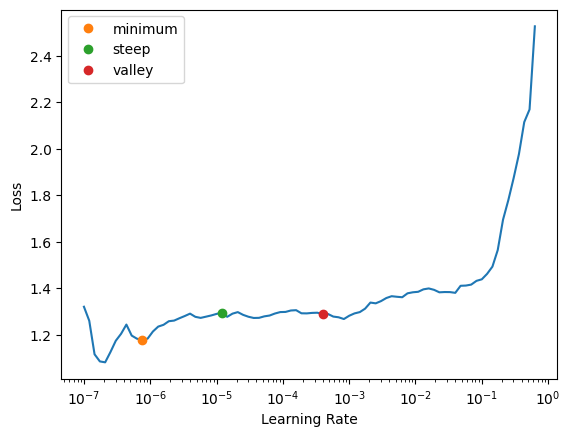

In [8]:
# Finds learning rates and prints plot of loss vs learning rate.

lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley))

In [9]:
# Train the model with the valley learning rate. 
# Reduced number of epochs for initial training to 2 epochs due to kaggle's 12 hour session time limit.

learn.fit_one_cycle(2, lrs.valley, cbs=early_stopping_cb)

# This learning rate below has higher accuracy, but takes 3x as long per epoch. 
# This learning rate represents a small range around the steepest point at the minimum value.

#learn.fit_one_cycle(4, slice(lrs.minimum, lrs.steep), cbs=early_stopping_cb)   

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.882741,0.717193,0.556000,0.557503,0.542933,0.550122,2:07:59
1,0.761026,0.681072,0.574667,0.570281,0.605867,0.587536,2:03:53


In [10]:
# Fine-tune the model, again, reduced from 20 epochs down to only 2 due to time-limit restrictions.

learn.fit_one_cycle(2, lrs.valley, cbs=early_stopping_cb)

# Ideal implementation below.

#learn.fit_one_cycle(20, slice(lrs.minimum, lrs.steep), cbs=early_stopping_cb)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,0.703934,0.682814,0.575733,0.553223,0.787200,0.649791,2:20:05
1,0.683806,0.667233,0.595467,0.590404,0.623467,0.606485,2:19:21


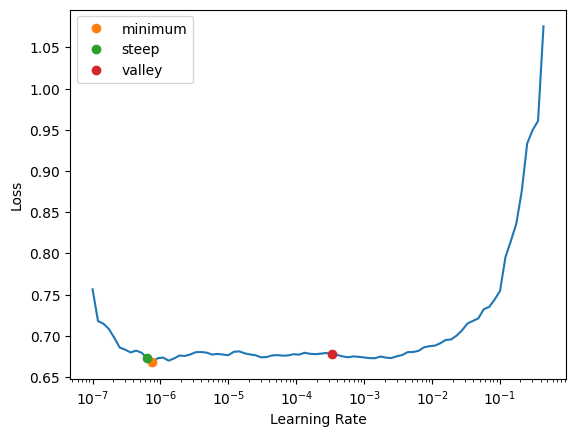

In [11]:
# Unfreeze the model and find a new learning rate (hyperparameter tuning).

learn.unfreeze()
lrs_finetune = learn.lr_find(suggest_funcs=(minimum, steep, valley))

In [13]:
# Continue fine-tuning with the new learning rates.

learn.fit_one_cycle(2, lrs_finetune.valley, cbs=early_stopping_cb)

# Ideal implementation below.

#learn.fit_one_cycle(10, slice(lrs.minimum, lrs.steep), cbs=early_stopping_cb)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time


KeyboardInterrupt: 

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

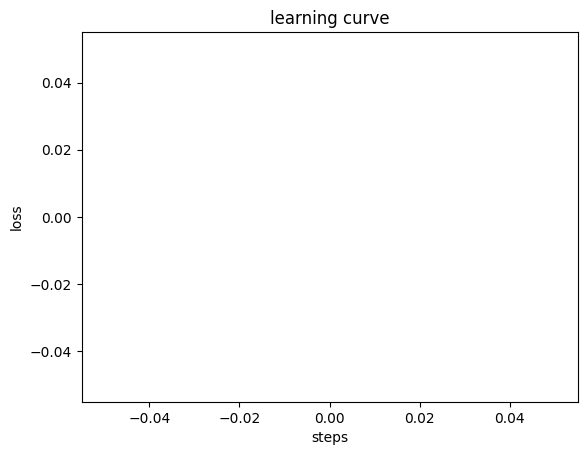

In [14]:
# Plot the learning curve. Steps vs Loss.

learn.recorder.plot_loss(with_valid=False)

In [ ]:
# Plot a confusion matrix.

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Load the test dataset.

test_dl = learn.dls.test_dl(get_image_files(test_path), with_labels=True)

In [ ]:
# Calculate accuracy on the test dataset

test_accuracy = learn.validate(dl=test_dl)[1]
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict diagnosis on a single image from the test set with confidence percentage.

img = PILImage.create('/kaggle/input/full-dataset/kaggle/working/val/pneumonia/0175a8d3-997212d8-5bff4e5b-a748a75c-86eb2fa6.jpg')

prediction, _, probabilities = learn.predict(img)

predicted_class = prediction
confidence = probabilities.max().item()

print(f"Prediction: {predicted_class}, Certainty: {confidence:.4f}")

In [ ]:
# Display heatmap of the areas of the image the CNN focused on most when determining decision.

from fastai.vision.all import *
import matplotlib.pyplot as plt
import cv2

def get_gradcam_heatmap(img_tensor, learn, class_idx=None, layer_idx=-2):
    m = learn.model.eval()
    device = next(m.parameters()).device
    img_tensor = img_tensor.to(device).unsqueeze(0)
    
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0])

    layer = m[layer_idx]
    forward_hook_handle = layer.register_forward_hook(forward_hook)
    backward_hook_handle = layer.register_backward_hook(backward_hook)
    
    output = m(img_tensor)
    if class_idx is None:
        class_idx = torch.argmax(output)
    m.zero_grad()
    output[0, class_idx].backward()
    
    forward_hook_handle.remove()
    backward_hook_handle.remove()
    
    activations = activations[0].detach().cpu()
    gradients = gradients[0].detach().cpu()
    
    pooled_grads = gradients.mean(dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[0, i, :, :] *= pooled_grads[i]

    heatmap = activations.mean(dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    return heatmap

def display_gradcam(img_path, learn, class_idx=None, layer_idx=-2):
    img = PILImage.create(img_path)
    
    img_tensor = learn.dls.test_dl([img]).one_batch()[0][0]  #apply test_dl transformations.
    
    heatmap = get_gradcam_heatmap(img_tensor, learn, class_idx, layer_idx)

    #convert the image tensor to a NumPy array for visualization.
    img_np = np.array(img_tensor.permute(1, 2, 0))
    img_np = img_np - img_np.min()
    img_np = img_np / img_np.max()

    #resize and apply a colour map to the heatmap.
    heatmap = cv2.resize(heatmap.numpy(), (img_np.shape[1], img_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    #superimpose the heatmap on the original image.
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.uint8(255 * img_np), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)

    #display the original image and the Grad-CAM heatmap.
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Grad-CAM')
    plt.axis('off')
    
    plt.show()

In [ ]:
# Test image using Grad-CAM.

img_path = '/kaggle/input/full-dataset/kaggle/working/val/pneumonia/0175a8d3-997212d8-5bff4e5b-a748a75c-86eb2fa6.jpg'
display_gradcam(img_path, learn)